# **📝 Text Summarization**

---

## **🛩 Importing packages**

In [1]:
import re
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Input, TimeDistributed

In [2]:
!pip freeze > requirements.txt

In [3]:
try:
    # spacy is used in Data Cleaning section
    # if gpu is available then this configuration will speed up the process
    spacy.prefer_gpu()
except Exception as e:
    print(e)

## **🚛 Getting the data**

In [4]:
filename1 = '../input/news-summary/news_summary.csv'
filename2 = '../input/news-summary/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [5]:
df1.head(2)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."


In [6]:
df2.head(2)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...


In [7]:
# concatinating all columns (except summary) string (sep: ' ')
df1['text'] = df1['author'].str.cat(df1['date'].str.cat(df1['read_more'].str.cat(df1['text'].str.cat(df1['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

df1 = df1.drop(['author', 'date', 'read_more', 'ctext'], axis=1)
df1.head()

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,"Chhavi Tyagi 03 Aug 2017,Thursday http://www.h..."
1,Malaika slams user who trolled her for 'divorc...,"Daisy Mowke 03 Aug 2017,Thursday http://www.hi..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,"Arshiya Chopra 03 Aug 2017,Thursday http://www..."
3,Aaj aapne pakad liya: LeT man Dujana before be...,"Sumedha Sehra 03 Aug 2017,Thursday http://indi..."
4,Hotel staff to get training to spot signs of s...,"Aarushi Maheshwari 03 Aug 2017,Thursday http:/..."


In [8]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df.columns = ['summary', 'text']
df.head()

,summary,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,"Chhavi Tyagi 03 Aug 2017,Thursday http://www.h..."
1,Malaika slams user who trolled her for 'divorc...,"Daisy Mowke 03 Aug 2017,Thursday http://www.hi..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,"Arshiya Chopra 03 Aug 2017,Thursday http://www..."
3,Aaj aapne pakad liya: LeT man Dujana before be...,"Sumedha Sehra 03 Aug 2017,Thursday http://indi..."
4,Hotel staff to get training to spot signs of s...,"Aarushi Maheshwari 03 Aug 2017,Thursday http:/..."


## **🛁 Data cleaning**

In [9]:
def clean_text(column):
    for row in column:
        row = re.sub("(\\t)", ' ', str(row)).lower()
        row = re.sub("(\\r)", ' ', str(row)).lower()
        row = re.sub("(\\n)", ' ', str(row)).lower()

        row = re.sub("(__+)", ' ', str(row)).lower()
        row = re.sub("(--+)", ' ', str(row)).lower()
        row = re.sub("(~~+)", ' ', str(row)).lower()
        row = re.sub("(\+\++)", ' ', str(row)).lower()
        row = re.sub("(\.\.+)", ' ', str(row)).lower()

        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()

        row = re.sub("(mailto:)", ' ', str(row)).lower()
        row = re.sub(r"(\\x9\d)", ' ', str(row)).lower()
        row = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower()
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower()

        row = re.sub("(\.\s+)", ' ', str(row)).lower()
        row = re.sub("(\-\s+)", ' ', str(row)).lower()
        row = re.sub("(\:\s+)", ' ', str(row)).lower()
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower()

        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(row))
        except:
            pass

        row = re.sub("(\s+)", ' ', str(row)).lower()
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower()

        yield row


text_cleaning = clean_text(df['text'])
summary_cleaning = clean_text(df['summary'])

In [10]:
# disabling Named Entity Recognition for speed
nlp = spacy.load('en', disable=['ner', 'parser'])

# Taking advantage of spaCy .pipe() method to speed-up the cleaning process
# If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell, decrease the batch_size parametre 

# Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(text_cleaning, batch_size=5000, n_threads=-1)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(summary_cleaning, batch_size=5000, n_threads=-1)]

In [11]:
text[0]

'chhavi tyagi 03 aug 2017 thursday www.hindustantimes.com utm_source=inshorts utm_medium=referral utm_campaign=fullarticle the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media the daman and diu administration on wednesday withdrew circular that asked women staff to tie rakhis on male colleagues after the order triggered backlash from employees and was ripped apart on social media.the union territory administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace it has been decided to celebrate the festival of rakshabandhan on august in this connection all offices/ departments shall remain open and c

In [12]:
summary[0]

'_START_ daman diu revokes mandatory rakshabandhan in offices order _END_'

In [13]:
df = pd.DataFrame({'text': text, 'summary': summary})
df.head()

,text,summary
0,chhavi tyagi 03 aug 2017 thursday www.hindusta...,_START_ daman diu revokes mandatory rakshaband...
1,daisy mowke 03 aug 2017 thursday www.hindustan...,_START_ malaika slams user who trolled her for...
2,arshiya chopra 03 aug 2017 thursday www.hindus...,_START_ virgin now corrected to unmarried in ...
3,sumedha sehra 03 aug 2017 thursday indiatoday....,_START_ aaj aapne pakad liya let man dujana be...
4,aarushi maheshwari 03 aug 2017 thursday indiat...,_START_ hotel staff to get training to spot si...


In [14]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

## **🔦 Data analysis**

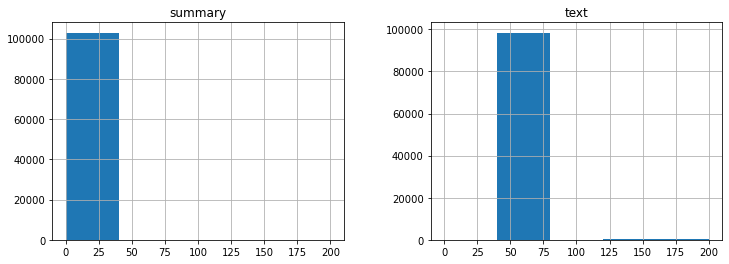

In [15]:
text_count = [len(sentence.split()) for sentence in df.text]
summary_count = [len(sentence.split()) for sentence in df.summary]

pd.DataFrame({'text': text_count, 'summary': summary_count}).hist(
    bins=5, figsize=(12, 4), range=[0, 200]
)
plt.show()

In [16]:
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count/len(column), 2)


# Check how many % of summary have 0-15 words
print(get_word_percent(df.summary, 15))

# Check how many % of summary have 0-80 words
print(get_word_percent(df.text, 80))

1.0
0.96


In [17]:
max_text_len = 80
max_summary_len = 15

In [18]:
cleaned_text = np.array(df['text'])
cleaned_summary = np.array(df['summary'])

# select the summary and text between their defined respective max lens
short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_text[i].split()) <= max_text_len and len(cleaned_summary[i].split()) <= max_summary_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({'text': short_text, 'summary': short_summary})

In [19]:
start_token = 'sostok'
end_token = 'eostok'

# adding start & end token in the start & end of each summary
df.summary = df.summary.apply(lambda x: f'{start_token} {x} {end_token}')
df.head()

,text,summary
0,nan,sostok _START_ air india current business is n...
1,nan,sostok _START_ delhi woman alleges in-laws set...
2,nan,sostok _START_ people count my failures don sa...
3,nan,sostok _START_ us mandates explosive trace che...
4,nan,sostok _START_ 16-year-old golfer diksha dagar...


> **sostok** & **eostok** tokens are for us to know where to start & stop the summary because using _START_ & _END_, tf's tokenizer with convert them to **start** & **end** respectively. 

> So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use _START_ & _END_ tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

> So we can just use these **sostok** & **eostok** instead of _START_ & _END_, well you can but I tried both ways and while not using these _START_ & _END_ I was getting undesired results 🤯 😅

## **🤹‍♂️ Data preprocessing**

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']), np.array(df['summary']),
    test_size=0.1, random_state=1, shuffle=True
)

In [21]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count/total_count)*100, 2),
        'total_coverage': round(frequency/total_frequency*100, 2),
        'count': count,
        'total_count': total_count
    }

#### **🍔 X's tokenization**

In [22]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 57.91, 'total_coverage': 1.34, 'count': 45874, 'total_count': 79215}


In [23]:
# 🔥 to increase computation speed use this
# x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])

# else use this
x_tokenizer = Tokenizer()

x_tokenizer.fit_on_texts(list(x_train))

In [24]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

79216


#### **🍕 Y's tokenization**

In [26]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 66.3, 'total_coverage': 3.56, 'count': 22775, 'total_count': 34349}


In [27]:
# 🔥 to increase computation speed use this
# y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])

# else use this
y_tokenizer = Tokenizer()

y_tokenizer.fit_on_texts(list(y_train))

In [28]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

34350


In [30]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

In [31]:
y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## **👯‍♀️ Modelling**

In [32]:
latent_dim = 240
embedding_dim = 240

In [33]:
tf.keras.backend.clear_session()

In [34]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [35]:
# Model with just LSTM layers
def build_basic_seq2seq_model(embedding_dim, latent_dim, max_text_len, x_vocab_size, y_vocab_size):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():
    
        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len,))

        # encoder embedding layer
        encoder_embedding = Embedding(x_vocab_size, embedding_dim, trainable=True)(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None,))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(y_vocab_size, embedding_dim, trainable=True)
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
        decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states)

        # dense layer
        decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()


        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [36]:
# Model with Bidirection layers
def build_bi_seq2seq_model(embedding_dim, latent_dim, max_text_len, x_vocab_size, y_vocab_size):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len,))

        # encoder embedding layer
        encoder_embedding = Embedding(x_vocab_size, embedding_dim, trainable=True)(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(encoder_embedding)
        encoder_bi_lstm1_output = [encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(encoder_output1)
        encoder_bi_lstm2_output = [encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)


        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None,))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(y_vocab_size, embedding_dim, trainable=True)
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1 (this bidirectional lstm one gives error running the decoder inferences part of it)
        # ValueError: Layer bidirectional_3 expects 3 inputs, but it received 1 input tensors. Inputs received: [<tf.Tensor 'model_7/embedding_1/embedding_lookup/Identity:0' shape=(None, 1, 200) dtype=float32>]
        # After replacing bidirectional lstm with just lstm the performance decreases
        # decoder_bi_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True,return_state=True, dropout=0.4, recurrent_dropout=0.2))
        # decoder_output, *decoder_final_states = decoder_bi_lstm(decoder_embedding, initial_state=encoder_final_states)
        
        decoder_bi_lstm = LSTM(latent_dim, return_sequences=True,return_state=True, dropout=0.4, recurrent_dropout=0.2)
        decoder_output, *decoder_final_states = decoder_bi_lstm(decoder_embedding, initial_state=encoder_final_states[:2]) # taking only the forward states        
        
        # dense layer
        decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()


        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
        
        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [37]:
# Using model with just lstms
seq2seq = build_basic_seq2seq_model(embedding_dim, latent_dim, max_text_len, x_vocab_size, y_vocab_size)
# If you want to change model then just change the function above

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 240)      19011840    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 240), (N 461760      embedding[0][0]                  
______________________________________________________________________________________________

In [38]:
model.layers[-2].input

[<tf.Tensor 'embedding_1/Identity:0' shape=(None, None, 240) dtype=float32>,
 <tf.Tensor 'lstm_1/Identity_1:0' shape=(None, 240) dtype=float32>,
 <tf.Tensor 'lstm_1/Identity_2:0' shape=(None, 240) dtype=float32>]

In [39]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', mode='min', verbose=1, patience=2),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=1, min_lr=0.000001, verbose=1),
]

In [40]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=50,
    batch_size=128*tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]], 
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
87/87 [==============================] - 16s 179ms/step - loss: 6.4751 - val_loss: 5.6592 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 7s 78ms/step - loss: 5.6076 - val_loss: 5.3496 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 7s 78ms/step - loss: 5.4116 - val_loss: 5.2565 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 7s 78ms/step - loss: 5.3204 - val_loss: 5.2010 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 7s 78ms/step - loss: 5.2357 - val_loss: 5.1491 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 7s 78ms/step - loss: 5.1453 - val_loss: 5.0430 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 7s 78ms/step - loss: 5.0344 - val_loss: 4.9443 - lr: 0.0010
Epoch 8/50
87/87 [==============================] - 7s 78ms/step - loss: 4.9150 - val_loss: 4.8333 - lr: 0.0010
Epoch 9/50
87/87 [==============================] - 7s 78ms/step - loss: 4.8093 - val_loss: 4.7488 - l

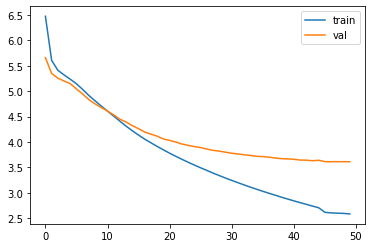

In [41]:
# Loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

### **⚡️ Inference**

In [42]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [43]:
def build_basic_seq2seq_model_inference(
    max_text_len, latent_dim,
    encoder_input, encoder_output, encoder_final_states,
    decoder_input, decoder_output, 
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_input, outputs=[encoder_output] + encoder_final_states)
    
    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))
    
    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)
    
    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )
    
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)
    
    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )
    
    return (encoder_model, decoder_model)

In [44]:
def build_bi_seq2seq_model_inference(
    max_text_len, latent_dim,
    encoder_input, encoder_output, encoder_final_states,
    decoder_input, decoder_output, 
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):
    
    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_input, outputs=[encoder_output] + encoder_final_states)
    
    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim,))
    decoder_state_forward_input_c = Input(shape=(latent_dim,))
    decoder_state_backward_input_h = Input(shape=(latent_dim,))
    decoder_state_backward_input_c = Input(shape=(latent_dim,))    
    
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))
    
    decoder_initial_state = [
        decoder_state_forward_input_h,
        decoder_state_forward_input_c,
        # decoder_state_backward_input_h,
        # decoder_state_backward_input_c
    ]
    
    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)
    
    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )
    
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)
    
    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )
    
    return (encoder_model, decoder_model)

In [45]:
encoder_model, decoder_model = build_basic_seq2seq_model_inference(max_text_len, latent_dim, encoder_input, encoder_output, encoder_final_states, decoder_input, decoder_output, decoder_embedding_layer, decoder_dense, last_decoder_lstm)

In [46]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 240)           19011840  
_________________________________________________________________
lstm (LSTM)                  [(None, 80, 240), (None,  461760    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 80, 240), (None,  461760    
Total params: 19,935,360
Trainable params: 19,935,360
Non-trainable params: 0
_________________________________________________________________


In [47]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 240)    8244000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [48]:
decoder_model.layers[-3].input

[<tf.Tensor 'embedding_1/Identity:0' shape=(None, None, 240) dtype=float32>,
 <tf.Tensor 'lstm_1/Identity_1:0' shape=(None, 240) dtype=float32>,
 <tf.Tensor 'lstm_1/Identity_2:0' shape=(None, 240) dtype=float32>]

In [49]:
def decode_sequence_for_basic_seq2seq_model(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [50]:
def decode_sequence_for_bi_seq2seq_model(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict([target_seq] + [e_out] + state_values)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [51]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if((i != 0 and i != target_word_index[start_token]) and (i != target_word_index[end_token])):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [52]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i+lst_i])
    
print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


In [53]:
# For predicting unseen data
# pass decode_sequence function for which you want to decode
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text]) # generator
    text_list = original_text.split()
    
    if len(text_list) <= max_text_len:
        text = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(text, batch_size=5000, n_threads=-1)][0]
        text = f'{start_token} {text} {end_token}'
        
        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(padded.reshape(1, max_text_len), encoder_model, decoder_model)
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')
        
        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i+lst_i]
            _text = ' '.join(_text_list)            
            _text = ' '.join(_text.split())  # to remove spaces that were added to make len(text_list) % max_text_len == 0
            
            _text = clean_text([_text]) # generator
            _text = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(_text, batch_size=5000, n_threads=-1)][0]
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(_padded.reshape(1, max_text_len), encoder_model, decoder_model)
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())
            
        return pred_summary

## **🔮 Predictions**

In [54]:
# Testing on training data

for i in range(0, 50):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print("Predicted summary: ", decode_sequence_for_basic_seq2seq_model(x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model))
    print()

# 1 News:  indigo has issued clarification after twitter account called presidentverde shared fake images about the airline introducing manhandling services with immediate effect presidentverde also retweeted post by another account trolling the airline the airline has been slammed after video of fight between passenger and its staffers went viral 
Original summary:  start indigo says tweet offering manhandling services is fake end 
Predicted summary:   start indigo ceo slams airline for not paying for fake news end

# 2 News:  security researcher jackie stokes has claimed that an unnamed facebook employee stalked women online through privileged access of the company resources have tinder logs what should do with this information she tweeted in response facebook said it is already investigating the matter and added that the company could not comment on individual personnel matters 
Original summary:  start fb employee accused of using firm resources to stalk women end 
Predicted summar

## **🎁 Saving the model**

In [55]:
# HDF5 format
model.save('model.h5')    
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

---